## makemore: part 5

In [55]:
# Import libraries 
import math 
import random
import torch
import torch.nn as nn 
import torch.nn.functional as F
import matplotlib.pyplot as plt         # for making figures
%matplotlib inline
from typing import Union, Dict, Tuple, List, Any 
from IPython.display import clear_output
import capra_standard_functions as csf 

In [56]:
# Here we will import the list with all the words/names 
import os 
words_txt_file_path = os.path.join(os.path.expanduser("~"), "NN_zero_to_hero", "Lectures", "Makemore_repo", "names.txt")
words = open(words_txt_file_path, 'r').read().splitlines()

print(f"Now we have read the {len(words)} words from the file. Here we display the first 8 words\n{words[:8]}")

Now we have read the 32033 words from the file. Here we display the first 8 words
['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']


In [57]:
### Here we are building the vocabulary and mapping from char to integer and vice versa 
chars = sorted(list(set(''.join(words))))           # Read all unique characters in all words 
s_to_i = {s:i+1 for i,s in enumerate(chars)}        # Create a mapping from char to index integer
s_to_i['.'] = 0                                     # Assign the index of our special start/end token '.' to 0
i_to_s = {i:s for s,i in s_to_i.items()}            # Reverse the mapping from integer to char 
num_classes = len(s_to_i)                           # Read the different number of characters available in our dataset 
vocab_size = num_classes                            # Vocabulary = number of different tokens available for the model 

print(f"Now we have created the mappings between chars and integers and vice versa, which yields to {num_classes} different, possible characters (i.e. classes) in our dataset:\n{s_to_i=}\n{i_to_s=}")

Now we have created the mappings between chars and integers and vice versa, which yields to 27 different, possible characters (i.e. classes) in our dataset:
s_to_i={'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5, 'f': 6, 'g': 7, 'h': 8, 'i': 9, 'j': 10, 'k': 11, 'l': 12, 'm': 13, 'n': 14, 'o': 15, 'p': 16, 'q': 17, 'r': 18, 's': 19, 't': 20, 'u': 21, 'v': 22, 'w': 23, 'x': 24, 'y': 25, 'z': 26, '.': 0}
i_to_s={1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [58]:
# shuffle up the words
import random
random.seed(42)
random.shuffle(words)

In [59]:
### Build the dataset

# Create the dataset arrays from the words list
def build_dataset(words, s2i: Dict = s_to_i, block_size: int = 3, num_words: Union[int, None] = None, ):  
  X, Y = [], []
  for w in (words if num_words is None else words[:num_words] if isinstance(words[:num_words], list) else [words[:num_words]]): 
    context = [0] * block_size
    for ch in w + '.':
      ix = s2i[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix]                              # crop and append the next character to the context
  return torch.tensor(X), torch.tensor(Y)


# Print metadata 
random.seed(42)                                                 # Choose a seed for deterministic shuffling 
random.shuffle(words)                                           # inplace shuffling of the words list 
n1 = int(0.8*len(words))                                        # Extract an integer for the 80% of the dataset 
n2 = int(0.9*len(words))                                        # Extract an integer for the 90% of the dataset 

block_size = 8                                                  # context length: how many characters do we take to predict the next one?
Xtr,  Ytr  = build_dataset(words[:n1], block_size=block_size)   # Build the training split 
Xdev, Ydev = build_dataset(words[n1:n2], block_size=block_size) # Build the validation (dev) split 
Xte,  Yte  = build_dataset(words[n2:], block_size=block_size)   # Build the test split 


In [60]:
# Print the first 20 sequences 
for x,y in zip(Xtr[:20], Ytr[:20]):
  print(''.join(i_to_s[ix.item()] for ix in x), '-->', i_to_s[y.item()])

........ --> e
.......e --> b
......eb --> r
.....ebr --> i
....ebri --> m
...ebrim --> a
..ebrima --> .
........ --> h
.......h --> i
......hi --> l
.....hil --> t
....hilt --> o
...hilto --> n
..hilton --> .
........ --> j
.......j --> h
......jh --> e
.....jhe --> n
....jhen --> e
...jhene --> .


In [61]:
### Near copy paste of the layers we have developed in Part 3 - Batch Norm lecture 
# We want to use these differenct class instances in order to be able to stack them as different blocks on top of each other 
# This makes is very easy to simply instantiate new instances from each of these classes to create or extend a new network 
# PyTorch has similar layers (with similar names) for all these new layers that we are using here 

# -----------------------------------------------------------------------------------------------
class Linear:
  
  def __init__(self, fan_in, fan_out, bias=True):
    self.weight = torch.randn((fan_in, fan_out)) / fan_in**0.5 # note: kaiming init, not necessary due to BatchNorm 
    self.bias = torch.zeros(fan_out) if bias else None
  
  def __call__(self, x):
    self.out = x @ self.weight
    if self.bias is not None:
      self.out += self.bias
    return self.out
  
  def parameters(self):
    return [self.weight] + ([] if self.bias is None else [self.bias])

# -----------------------------------------------------------------------------------------------
class BatchNorm1d:
  """
  Notice that the running mean and variance is "trained" as an exponential moving average during the training, i.e. not trained with backprop 
  Notice that the layer acts differently during eval and training, this makes BatchNorm vulnerable to bugs and issues 
  Notice that batch norm requires a training batch size of bs>=2, as we cannot calculate the variance of a single sample ... 
  """
  
  def __init__(self, dim, eps=1e-5, momentum=0.1):
    self.eps = eps
    self.momentum = momentum
    self.training = True
    # parameters (trained with backprop)
    self.gamma = torch.ones(dim)
    self.beta = torch.zeros(dim)
    # buffers (trained with a running 'momentum update')
    self.running_mean = torch.zeros(dim)
    self.running_var = torch.ones(dim)
  
  def __call__(self, x):
    # calculate the forward pass
    if self.training:
      if x.ndim == 2:
        dim = 0
      elif x.ndim == 3:
        dim = (0,1)
      xmean = x.mean(dim, keepdim=True) # batch mean
      xvar = x.var(dim, keepdim=True) # batch variance
    else:
      xmean = self.running_mean
      xvar = self.running_var
    xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
    self.out = self.gamma * xhat + self.beta
    # update the buffers
    if self.training:
      with torch.no_grad():
        self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
        self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
    return self.out
  
  def parameters(self):
    return [self.gamma, self.beta]

# -----------------------------------------------------------------------------------------------
class Tanh:
  def __call__(self, x):
    self.out = torch.tanh(x)
    return self.out
  def parameters(self):
    return []

# -----------------------------------------------------------------------------------------------
class Embedding:
  """
  We have an embedding table, which we want to index into using:        emb = C[Xb]
  This we can do with this simple layer.
  We simply say that we want to initiate a random embedding matrix of the specified dimension
  The forward pass is then simply indexing into the embedding matrix 
  """
  def __init__(self, num_embeddings, embedding_dim):
    self.weight = torch.randn((num_embeddings, embedding_dim))
    
  def __call__(self, IX):
    self.out = self.weight[IX]
    return self.out
  
  def parameters(self):
    return [self.weight]

# -----------------------------------------------------------------------------------------------
class FlattenConsecutive:
  """
  This is a Flatten layer, that will flatten consecutive inputs
    Initially we would simply have a single Flatten layer with only the forward pass: self.out = x.view(x.shape[0], -1) and no parameters
  Flatten consecutive can view the input into multiple dimensions
    I.e. if we have an input array of (N, block_size, emb_dim) then a regular flatten would view this as a (N, block_size*emb_dim) --> i.e. our (32, 8, 10) would become (32, 80)
    However, now we don't want to squeeze all the blocks into the first linear layer at the same time, we want to fuse only two consecutive blocks at a time
  This means that as the input to FlattenConsecutive is still (32, 8, 10) then we now want the output to be (32, 4, 20)
    This is compatible with our Linear layer, which is simply a powerful Python matrix multiplication:
          (32, 80) @ (80, 200)    = (32, 200)
          (32, 4, 20) @ (20, 200) = (32, 4, 200) 
      Hence, notice here, that Python is performing a broadcast as the multiplication will only happen along the last dimension of the first matrix and the first dimension of the last matrix 
  """
  def __init__(self, n):
    self.n = n
    
  def __call__(self, x):
    B, T, C = x.shape
    x = x.view(B, T//self.n, C*self.n)
    if x.shape[1] == 1:
      x = x.squeeze(1)
    self.out = x
    return self.out
  
  def parameters(self):
    return []

# -----------------------------------------------------------------------------------------------
class Sequential:
  """
  This is a Sequential class => this is what's called a PyTorch container --> https://pytorch.org/docs/stable/generated/torch.nn.Sequential.html#torch.nn.Sequential 
  This container can simply contain all the layers added sequentially 
  This code is straight forward:
    We pass in a list of layers
    In the forward pass we then call all these layers sequentially one by one 
    The parameters are then the parameters for all the layers inside the 
  """
  
  def __init__(self, layers):
    self.layers = layers
  
  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    self.out = x
    return self.out
  
  def parameters(self):
    # get parameters of all layers and stretch them out into one list
    return [p for layer in self.layers for p in layer.parameters()]


In [62]:
# Discarded the generator object, now we simply set the manual seed for the entire notebook here instead 
torch.manual_seed(42);                      # seed rng for reproducibility

In [63]:
# original network
# n_embd = 10 # the dimensionality of the character embedding vectors
# n_hidden = 300 # the number of neurons in the hidden layer of the MLP
# model = Sequential([
#   Embedding(vocab_size, n_embd),
#   FlattenConsecutive(8), Linear(n_embd * 8, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
#   Linear(n_hidden, vocab_size),
# ])

# hierarchical network
n_embd = 24 # the dimensionality of the character embedding vectors
n_hidden = 128 # the number of neurons in the hidden layer of the MLP
model = Sequential([
  Embedding(vocab_size, n_embd),
  FlattenConsecutive(2), Linear(n_embd * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  FlattenConsecutive(2), Linear(n_hidden*2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  FlattenConsecutive(2), Linear(n_hidden*2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(n_hidden, vocab_size),
])

# parameter init
with torch.no_grad():
  model.layers[-1].weight *= 0.1              # last layer make less confident

parameters = model.parameters()               # Use model.parameters instead of 
print(sum(p.nelement() for p in parameters))  # number of parameters in total
for p in parameters:
  p.requires_grad = True

76579


In [64]:
# same optimization as last time
max_steps = 20000
batch_size = 32
lossi = []

for i in range(max_steps):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,))
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
  
  # forward pass
  logits = model(Xb)                  # This is the
  loss = F.cross_entropy(logits, Yb)  # loss function
  
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update: simple SGD
  lr = 0.1 if i < 150000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())


      0/  20000: 3.3088


  10000/  20000: 2.4522


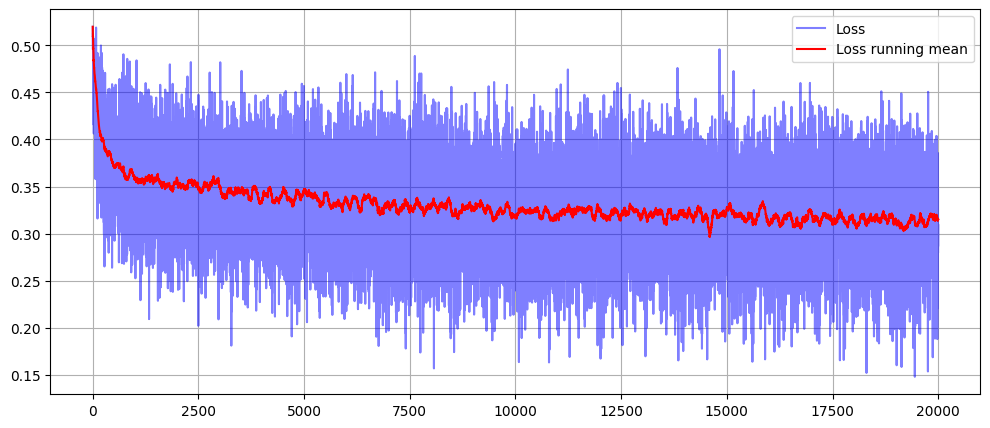

In [65]:
fig = plt.figure(figsize=(12,5))
plt.plot(lossi, color="blue", alpha=0.5, label="Loss")
avg_run_mean_loss = csf.moving_average(inp_array=lossi, n=100)
plt.plot(avg_run_mean_loss, color="red", label="Loss running mean")
plt.legend()
plt.grid(True)
plt.draw()

In [66]:
# put layers into eval mode (needed for batchnorm especially)
for layer in model.layers:
  layer.training = False

In [67]:
# evaluate the loss
@torch.no_grad() # this decorator disables gradient tracking inside pytorch
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  logits = model(x)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

### When the losses are very close to each other, we have a feeling that we are not overfitting the model, hence we might be able to increase capacity and still get a gain from that 
# Hence, we need to find the optimal way to increase the capacity of the network 
# At the moment it seems silly to squash the entire input sequence into the first layer with a massive receptive field -> we simply loose to much information in that way 
  # Hence, we want to implement a Wavenet like architecture with dilated convolutions 
  # At each layer we only want to merge two consecutive elements 

train 2.0422098636627197
val 2.0910122394561768


### performance log

- original (3 character context + 200 hidden neurons, 12K params): train 2.058, val 2.105
- context: 3 -> 8 (22K params): train 1.918, val 2.027
- flat -> hierarchical (22K params): train 1.941, val 2.029
- fix bug in batchnorm: train 1.912, val 2.022
- scale up the network: n_embd 24, n_hidden 128 (76K params): train 1.769, val 1.993


In [74]:
# sample from the model
for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      # forward pass the neural net
      logits = model(torch.tensor([context]))
      probs = F.softmax(logits, dim=1)
      # sample from the distribution
      ix = torch.multinomial(probs, num_samples=1).item()
      # shift the context window and track the samples
      context = context[1:] + [ix]
      out.append(ix)
      # if we sample the special '.' token, break
      if ix == 0:
        break
    
    print(''.join(i_to_s[i] for i in out)) # decode and print the generated word

kriema.
poyceon.
kleisangelie.
sylaynoh.
romarie.
eli.
wrodan.
blaige.
berias.
fllomr.
krialaya.
sui.
taemina.
ray.
shyatt.
armelik.
zamar.
rayleigh.
zenai.
wiliana.


### Next time:
Why convolutions? Brief preview/hint

In [78]:
for x,y in zip(Xtr[7:15], Ytr[7:15]):
  print(''.join(i_to_s[ix.item()] for ix in x), '-->', i_to_s[y.item()])

........ --> h
.......h --> i
......hi --> l
.....hil --> t
....hilt --> o
...hilto --> n
..hilton --> .
........ --> j


In [16]:
# forward a single example:
logits = model(Xtr[[7]])
logits.shape

torch.Size([1, 27])

In [17]:
# forward all of them
logits = torch.zeros(8, 27)
for i in range(8):
  logits[i] = model(Xtr[[7+i]])
logits.shape

torch.Size([8, 27])

In [18]:
# convolution is a "for loop"
# allows us to forward Linear layers efficiently over space